# 모델 학습/예측/평가



## Dataset

### 개요 
- train dataset
: 모델 학습을 위한 데이터
- validation dataset
: 모델 평가를 위한 데이터
- test dataset
: 모델의 일반화 성능 평가를 위한 데이터

```
좋은 validation dataset을 만드는 것은 중요하다.
일차적으로 validation dataset을 통해 모델의 성능을 평가 하고
test dataset을 이용해 일반화 성능을 평가하여 실제로 이 모델이 좋은 성능을 가질 수 있는지 평가한다.

왜냐하면 test데이터만으로 평가하면 오버피팅 문제가 발생하여 실제로 모델을 배포할 때 성능 실패로 이어질 수 있다.
```




![validationset](./validationset.png)




```
Kaggle competition에서 주어지는 데이터셋은 train, test dataset이다.
Kaggle에서 평가를 위한 제출이 제한되어 있기 때문에 참가자들은 주어진 train dataset을 
다시 train, validation set으로 나누어 사용한다.
이때 우리는 sklearn.train_test_split() method를 사용할 수 있다.

하지만 주의해야할 점은 데이터셋을 나눌 때는 서로 비슷한 데이터가 들어가면 오버피팅이 발생할 수 있다. 즉 서로 이질적인 데이터셋을 가지도록 나눠야 오버피팅을 방지할 수 있다.
```



### Unbalanced dataset

```
지도학습 모델을 만들 때 훈련 데이터셋의 target값이 어느 하나의 값으로만 몰려있다면 모델은 대부분의 예측을 그 값으로 하게 될것이다.
이러한 데이터셋을 unbalanced dataset 이라고 한다.
예: 사기검출, 이상검출 등

이러한 문제를 해결할 수 있는 방법중에
Oversampling(오버 샘플링)과 Undersampling(언더 샘플링)이 있다.
```
![sampling](./overundersampling.png)
```
- Undersampling : 많은 레이블을 가진 데이터세트를 적은 레이블을 가진 데이터세트 수준으로 감소시키며 샘플링 -> 언더피팅이 발생할 수 있음
- Oversampling : 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터세트 수준으로 증식시키며 샘플링 -> 원래 있던 데이터를 그대로 사용해 증식하면 그 데이터에 과도하게 맞춰지는 오버피팅이 발생할 수 있다. 그래서 약간의 변형을 주며 데이터를 증식시키는 SMOTE(Synthetic Monority Over-sampling Tech)를 사용할 수 있다. imbalanced-learn 패키지 이용
오버샘플링이 성능이 좋은 경우가 많아 주로 사용한다.


```


-----------------------------

# 4.9 실습- 캐글 신용카드 사기검출

### 1. 데이터 일차 가공 및 모델 학습/예측/평가

### 2. 중요 데이터 분포도 변환 후 모델 학습/예측/평가

### 3. 이상치 데이터 제거 후 모델 학습/예측/평가

### 4. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # 빨간색 경고문을 안뜨게 만듦
%matplotlib inline


card_df = pd.read_csv('./creditcard.csv')

print(card_df.shape)
card_df.head(3)

(284807, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

In [5]:
print(card_df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


**Columns**

Time : 모델링에 필요없는 작업용 속성

Amount : 신용카드 트랜잭션 금액

Class : 0-정상, 1-사기

Vn : 알 수 없음

**원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사하여 반환**

In [6]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

**train_test_split함수의 소스코드**

`Signature: train_test_split(*arrays, **options)
Source:   
def train_test_split(*arrays, **options):
    """Split arrays or matrices into random train and test subsets

    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.

    test_size : float, int or None, optional (default=None)
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also None, it will
        be set to 0.25.

    train_size : float, int, or None, (default=None)
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    shuffle : boolean, optional (default=True)
        Whether or not to shuffle the data before splitting. If shuffle=False
        then stratify must be None.

    stratify : array-like or None (default=None)
        If not None, data is split in a stratified fashion, using this as
        the class labels.

    Returns
    -------
    splitting : list, length=2 * len(arrays)
        List containing train-test split of inputs.

        .. versionadded:: 0.16
            If the input is sparse, the output will be a
            ``scipy.sparse.csr_matrix``. Else, output type is the same as the
            input type.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import train_test_split
    >>> X, y = np.arange(10).reshape((5, 2)), range(5)
    >>> X
    array([[0, 1],
           [2, 3],
           [4, 5],
           [6, 7],
           [8, 9]])
    >>> list(y)
    [0, 1, 2, 3, 4]

    >>> X_train, X_test, y_train, y_test = train_test_split(
    ...     X, y, test_size=0.33, random_state=42)
    ...
    >>> X_train
    array([[4, 5],
           [0, 1],
           [6, 7]])
    >>> y_train
    [2, 0, 3]
    >>> X_test
    array([[2, 3],
           [8, 9]])
    >>> y_test
    [1, 4]

    >>> train_test_split(y, shuffle=False)
    [[0, 1, 2], [3, 4]]

    """
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")
    test_size = options.pop('test_size', None)
    train_size = options.pop('train_size', None)
    random_state = options.pop('random_state', None)
    stratify = options.pop('stratify', None)
    shuffle = options.pop('shuffle', True)

    if options:
        raise TypeError("Invalid parameters passed: %s" % str(options))

    arrays = indexable(*arrays)

    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(n_samples, test_size, train_size,
                                              default_test_size=0.25)

    if shuffle is False:
        if stratify is not None:
            raise ValueError(
                "Stratified train/test split is not implemented for "
                "shuffle=False")

        train = np.arange(n_train)
        test = np.arange(n_train, n_train + n_test)

    else:
        if stratify is not None:
            CVClass = StratifiedShuffleSplit
        else:
            CVClass = ShuffleSplit

        cv = CVClass(test_size=n_test,
                     train_size=n_train,
                     random_state=random_state)

        train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(chain.from_iterable((_safe_indexing(a, train),
                                     _safe_indexing(a, test)) for a in arrays))`


**학습과 테스트 데이터 세트를 반환하는 함수 생성. 사전 데이터 처리가 끝난 뒤 해당 함수 호출**

In [8]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    # Stratified를 이용하면 target값 분포가 같게 데이터를 분할
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [9]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


### **Quiz1** : 위의 코드들을 이용하여 데이터프레임(df)를 입력으로 받고 train, validation, test dataset을 반환하는 함수를 만들어 보세요

각 데이터셋의 비율은 임의로 정해도 됩니담

In [ ]:
def get_train_validation_test_dataset():
    
    return 

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_validation_test_dataset(df)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)

print('평가 데이터 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)


오차 행렬
[[85281    14]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8627, 재현율: 0.5946,    F1: 0.7040, AUC:0.9587


In [13]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

**LightGBM 학습/예측/평가.**

(boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨.)  
   LightGBM 2.1.0 이상 버전에서 이와 같은 현상 발생 
   
   [Lightgbm.issues](https://github.com/microsoft/Lightgbm/issues/1487, "Lightgbm.issues")
   
   
   [Lightgbm.doc](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst#initscore_filename)
   
```
boost_from_average 🔗︎, default = true, type = bool
used only in regression, binary, multiclassova and cross-entropy applications
adjusts initial score to the mean of labels for faster convergence
```

The init_score value represents the prediction that you are trying to correct with the first boosting iteration

**init_score**은 첫 번째 부스팅 반복으로 수정하려는 예측을 나타낸다


![boosting](./boosting.png)

boost_from_average는 이 init_score를 target의 평균으로 초기화하는 parameter,
그래서 불균형한 target값을 가진 데이터에 사용하면 성능이 안좋아질 수 있음


In [20]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797


위의 과정은 일차적인 데이터 가공 후 그 데이터로 모델링하면 어느 정도의 성능이 나오는지 살펴본 과정이다.

일차적인 데이터 가공뿐만아니라 다음 과정과 같이 **feature engineering**을 수행하면 더 나은 성능을 얻을 수 있다.

### 중요 데이터 분포도 변환 후 모델 학습/예측/평가

**중요 feature의 분포도 확인**

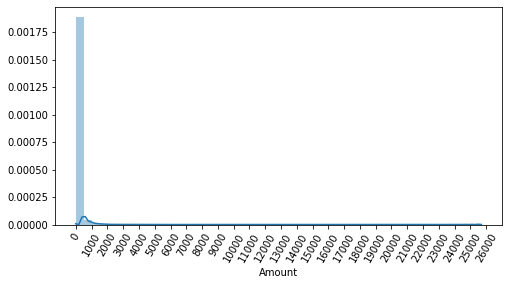

In [21]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

**데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피처 변환**

회귀모델은 정규분포를 가정하고 만들어진 모델이기 때문에 데이터가 정규분포와 비슷한 분포 형태를 유지하는 것이 유리하다

In [22]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가**

In [24]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9773


**정규분포 전환전 로지스틱 회귀 예측 성능**
```
오차 행렬
[[85281    14]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8627, 재현율: 0.5946,    F1: 0.7040, AUC:0.9587
```

**정규분포 전환전 LightGBM 예측 성능**
```
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797
```


회귀모델의 성능이 약간 좋아졌다.

### Quiz2 위의 코드를 이용하여 다른 feature에도 정규분포변환을 해준 후 모델의 성능평가를 해보세요

In [ ]:
#답

**Amount를 로그 변환**

로그변환을 통해 데이터의 분포를 작게 만들어주기

로그 변환을 하면 상대적으로 작은 값에 몰려 있는 데이터의 모양이 펴지면서 좌우대칭 형태로 분포의 모양이 달라진다.

분산을 줄여서 데이터안에 있는 극단값의 영향을 줄일 수 있다.

In [25]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [26]:
# log1p 와 expm1 설명 
import numpy as np

print(1e-1000 == 0.0)

print(np.log(1e-1000))

print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000))

# log1p를 쓰는 이유는 자연로그함수는 정의역이 0이 가까이 가면 -무한대로 수렴하기 때문

True
-inf
0.0
0.0


In [27]:
# 역함수 관계를 이용하여 로그변환값을 복구해줄 수 있음.
var_1 = np.log1p(100)
var_2 = np.expm1(var_1)
print(var_1, var_2)

4.61512051684126 100.00000000000003


In [28]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9786


**정규분포 전환전 로지스틱 회귀 예측 성능**
```
오차 행렬
[[85281    14]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8627, 재현율: 0.5946,    F1: 0.7040, AUC:0.9587
```

**정규분포 전환전 LightGBM 예측 성능**
```
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797
```


**정규분포 전환 후 로지스틱 회귀 예측 성능**
```
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
```

**정규분포 전환 후 LightGBM 예측 성능**
```
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9773
```

### 이상치 데이터 제거 후 모델 학습/예측/평가

Outlier(이상치 데이터) : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
모델의 성능에 영향읆 미친다.

IQR을 통해 이상치를 찾을 수 있다.
![iqr](./iqr2.png)

**각 피처들의 상관 관계를 시각화. 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출**

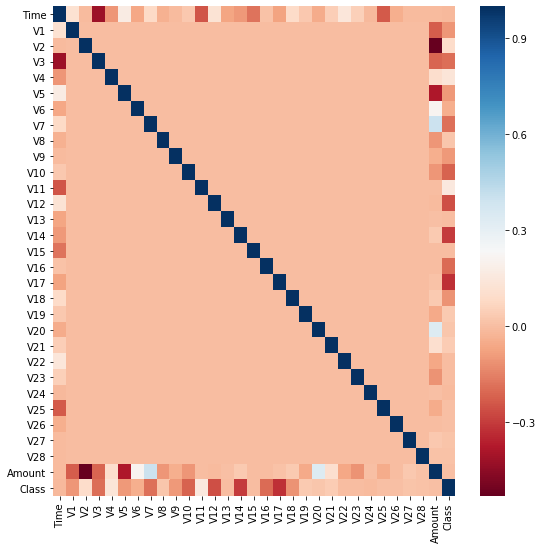

In [29]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [32]:
# 색으로 확인히기 힘들땐 수치로 볼수 있음
corr.sort_values(by='Class')['Class']

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

In [34]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index
    

In [36]:
np.max(card_df['V14']) == np.percentile(card_df['V14'].values, 100)

True

In [37]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


**로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재 학습/예측/평가**

In [38]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1: 0.8930, AUC:0.9831


**정규분포 전환전 로지스틱 회귀 예측 성능**
```
오차 행렬
[[85281    14]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8627, 재현율: 0.5946,    F1: 0.7040, AUC:0.9587
```

**정규분포 전환전 LightGBM 예측 성능**
```
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797
```


**정규분포 전환 후 로지스틱 회귀 예측 성능**
```
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
```

**정규분포 전환 후 LightGBM 예측 성능**
```
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9773
```

**로그변환후 로지스틱 회귀 예측 성능**
```
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
```

**로그변환후 LightGBM 예측 성능**
```
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9786
```

### Quiz3 V14보다 상관도가 높았던 V17을 로그변환, 이상치 제거 후 모델성능을 평가해 보세요.

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

학습데이터에만 적용하고 평가 데이터셋들에는 적용하지 말아야한다. 성능평가를 제대로 하기 위해서

In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

Using TensorFlow backend.


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


In [40]:
y_train.value_counts()

0    199020
1       342
Name: Class, dtype: int64

**로지스틱 회귀로 학습/예측/평가**

In [41]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)


오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


정밀도가 많이 내려가는 것을 확인할 수 있다

![confusion_matrix](./confusionmat.png)

![precision](./precision.png)


실제보다 많은 class 1을 학습함으로써 실제보다 지나치게 1로 예측해서 정밀도가 내려갔다.

**Precision-Recall 곡선 시각화**

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    


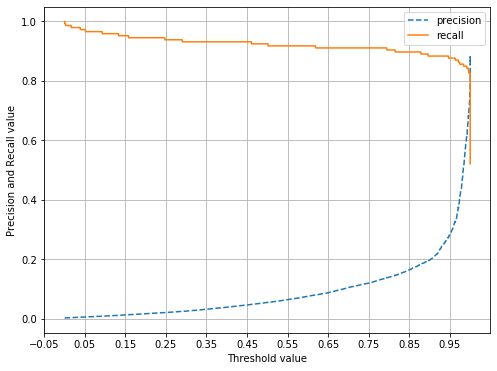

In [43]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

임계값에 따라 최적의 정밀도/재현율을 찾을 수 없다

**LightGBM 모델 적용**

In [44]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493,    F1: 0.8889, AUC:0.9789


------------------------------

# 4.10 Stacking ensemble

## 기본 Stacking ensemble

## CV 셋 기반의 Stacking

스태킹 모델: 개별적인 모델들의 예측값을 메타모델의 학습데이터로 사용하는 모델

![stacking1](./stacking1.png)

![stacking2](./stacking2.png)




### 기본 stacking

In [45]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

**개별 Classifier와  최종 Stacking 데이터를 학습할 메타 Classifier 생성**

In [46]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)


**개별 classifier 학습/예측/평가**

In [47]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [48]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 :


**개별 모델의 예측 결과를 메타 모델이 학습할 수 있도록 스태킹 형태로 재 생성** 

In [52]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print('pred.shape: ',pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print('pred.transpose.shape: ',pred.shape)

print('X_test.shape :',X_test.shape)

pred.shape:  (4, 114)
pred.transpose.shape:  (114, 4)
X_test.shape : (114, 30)


**메타 모델 학습/예측/평가**

In [53]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


### CV셋 기반의 Stacking

위의 기본 stacking모델은 test데이터로 메타모델을 적합시키기 때문에 오버피팅문제가 발생한다.

그래서 CV셋을 이용해 stacking에서 메타모델을 위한 train, test 데이터셋을 나눠줄 수 있다.

![cvstacking1](./cvstacking1.png)


위의 과정은 cv의 fold횟수 만큼 수행된다.

![cvstacking2](./cvstacking2.png)

위와같은 과정을 거쳐 원본 데이터의 train set을 이용해 메타모델을 위한 train set을 만들고 원본데이터의 test set을 이용해 메타모델을 위한 test set을 만들 수 있다.

결과적으로 메타모델을 test데이터로 적합시키지 않아 오버피팅을 방지할 수 있다.

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [55]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [56]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [57]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


### Quiz 메타모델을 다른모델을 이용해서 예측을 수행해보세요!

-------------------------------------

# BaysianOptimization을 이용한 하이퍼 파라미터 튜닝

출처:
[저자깃헙](https://github.com/chulminkw/PerfectGuide/tree/master/4%EC%9E%A5)

참고:
[BaysianOptimization깃헙](https://github.com/fmfn/BayesianOptimization), 
[sualab research blog](https://research.sualab.com/introduction/practice/2019/02/19/bayesian-optimization-overview-1.html)


하이퍼 파라미터 튜닝 대상을 Dictionary 형태로 정의합니다. 이때 개별 하이퍼 파라미터는 튜플형태의 범위값으로 주어집니다. 

예를 들어 num_leaves의 값을 24~45 사이의 값을 입력하려면 'num_leaves':(24, 45)로 부여해야 합니다. 
    
이 때 유의해야 할 사항은 num_leaves는 정수형값만 가능한 하이퍼 파라미터임에도 불구하고 BaysianOptimization 클래스가 해당 파라미터의 범위값을 입력 받으면 이를 무조건 정수형이 아닌 실수형 값으로 
인식하여 값을 추출하는 것입니다. 즉 24.5, 25.4, 30.2, 27.2 와 같이 실수형 값을 num_leaves 값으로 설정하려고 시도하는데, 이는 실행 오류를 발생 시킵니다.

이러한 실행 오류를 막기 위해서는 호출되는 BayesianOptimization 평가 함수내에서 XGBoost/LightGBM의 하이퍼 파라미터를 다시 정수형 값으로 변경하면 됩니다. 이에 대해서는 다시 뒤에서 언급하도록 하겠습니다. 

In [61]:
bayes_params = {
    'num_leaves': (24, 45),
    'colsample_bytree':(0.5, 1), 
    'subsample': (0.5, 1),
    'max_depth': (4, 12),
    'reg_alpha': (0, 0.5),
    'reg_lambda': (0, 0.5), 
    'min_split_gain': (0.001, 0.1),
    'min_child_weight':(5, 50)
}

테스트 해볼 하이퍼 파라미터의 범위 값을 설정하였으면 BaysianOptimization에서 호출하여 모델을 최적화하는 함수를 만들어 보겠습니다.

해당 함수는 BaysianOptimization에서 하이퍼 파라미터를 튜닝하기 위해 호출되면 제대로 튜닝이 되고 있는지를 판단하기 위해서 모델을 학습/평가하고 이에 따른 평가 지표를 반환하는 형식으로 만들어집니다. 이 평가 함수는 BayesianOptimization 객체에서 파라미터를 변경하면서 호출되므로 함수의 인자로 앞에서 딕셔너리로 설정된 파라미터들을 가지게 됩니다.  

In [62]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

def lgb_roc_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
    
    params = {
        "n_estimator":200,
        "learning_rate":0.02,
        'num_leaves': int(round(num_leaves)),
        'colsample_bytree': colsample_bytree, 
        'subsample': subsample,
        'max_depth': int(round(max_depth)),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbosity': -1
    }
    print("params:", params)
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, eval_metric="auc", verbose=100 )
    best_iter = lgb_model.best_iteration_
    print('best_iter:', best_iter)
    valid_proba = lgb_model.predict_proba(X_test, num_iteration=best_iter)[:, 1]
    roc_preds = roc_auc_score(y_test, valid_proba)
    print('roc_auc:', roc_preds)
    return roc_preds
    
    

BayesianOptimization 객체를 생성합니다. 
이때 생성 인자로 앞에서 만든 평가함수 lgb_roc_eval 함수와 튜닝할 하이퍼 파라미터의 범위값을 설정한 딕셔너리 변수인 bayes_params를 입력합니다

In [63]:
from bayes_opt import BayesianOptimization

BO_lgb = BayesianOptimization(lgb_roc_eval, bayes_params, random_state=0)


이제 입력받은 평가함수에 튜닝할 하이퍼 파라미터의 값을 반복적으로 입력하여 최적 하이퍼 파라미터를 튜닝할 준비가 되었습니다. 
BayesianOptimization객체에서 maximize()메소드를 호출하면 이를 수행할 수 있습니다. 

In [64]:
BO_lgb.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
params: {'n_estimator': 200, 'learning_rate': 0.02, 'num_leaves': 33, 'colsample_bytree': 0.7744067519636624, 'subsample': 0.9458865003910399, 'max_depth': 10, 'reg_alpha': 0.32294705653332806, 'reg_lambda': 0.21879360563134626, 'min_split_gain': 0.05494343511669279, 'min_child_weight': 32.12435192322397, 'verbosity': -1}
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	valid_0's auc: 0.993966	valid_0's binary_logloss: 0.354038
best_iter: 40
roc_auc: 0.9939663385201651
|  1        |  0.994    |  0.7744   |  9.722    |  32.12    |  0.05494  |  32.9     |  0.3229   |  0.2188   |  0.9459   |
params: {'n_estimator': 200, 'learning_rate': 0.02, 'num_leaves': 36, 'colsample_bytree': 0.981831380250514

params: {'n_estimator': 200, 'learning_rate': 0.02, 'num_leaves': 29, 'colsample_bytree': 0.9585208770550546, 'subsample': 0.9983679288354983, 'max_depth': 12, 'reg_alpha': 0.0259093247786511, 'reg_lambda': 0.1795689934156665, 'min_split_gain': 0.05223511019405629, 'min_child_weight': 14.146342893611944, 'verbosity': -1}
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.996507	valid_0's binary_logloss: 0.171953
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.996507	valid_0's binary_logloss: 0.223624
best_iter: 71
roc_auc: 0.9965068275643061
|  12       |  0.9965   |  0.9585   |  11.66    |  14.15    |  0.05224  |  29.34    |  0.02591  |  0.1796   |  0.9984   |
params: {'n_estimator': 200, 'learning_rate': 0.02, 'num_leaves': 44, 'colsample_bytree': 0.505529082153912, 'subsample': 0.890948798136555, 'max_depth': 4, 'reg_alpha': 0.074339221544861, 'reg_lambda': 0.49905536949079593, 'min_split_gain': 0.054754984202213704, 'min_child

BayesianOptimization 객체의 max 속성은 최고 높은 성능 Metric를 가질때의 하이퍼 파라미터 값을 가지고 있음.

In [67]:
BO_lgb.max

{'target': 0.9977770720863766,
 'params': {'colsample_bytree': 0.5142203306754479,
  'max_depth': 11.880213367965172,
  'min_child_weight': 17.89137764355987,
  'min_split_gain': 0.005372973870841626,
  'num_leaves': 24.18609808165061,
  'reg_alpha': 0.03895678030993932,
  'reg_lambda': 0.1282009077053714,
  'subsample': 0.6746530425398627}}

최고 높은 성능 Metric를 가질때의 하이퍼 파라미터 값을 이용해 lgbm다시 학습


**ROC AUC: 0.9978**

In [68]:
max_params = BO_lgb.max['params']

max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['max_depth'] = int(round(max_params['max_depth']))

lgbm_clf = LGBMClassifier(n_estimators=1000, learning_rate=0.02, **max_params)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.963957	valid_0's binary_logloss: 0.66815
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.979517	valid_0's binary_logloss: 0.654102
[3]	valid_0's auc: 0.991743	valid_0's binary_logloss: 0.639344
[4]	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.626265
[5]	valid_0's auc: 0.99222	valid_0's binary_logloss: 0.613133
[6]	valid_0's auc: 0.995713	valid_0's binary_logloss: 0.599534
[7]	valid_0's auc: 0.994125	valid_0's binary_logloss: 0.587849
[8]	valid_0's auc: 0.993808	valid_0's binary_logloss: 0.576569
[9]	valid_0's auc: 0.993808	valid_0's binary_logloss: 0.564468
[10]	valid_0's auc: 0.99349	valid_0's binary_logloss: 0.553225
[11]	valid_0's auc: 0.994125	valid_0's binary_logloss: 0.542422
[12]	valid_0's auc: 0.993966	valid_0's binary_logloss: 0.531889
[13]	valid_0's auc: 0.99476	valid_0's binary_logloss: 0.520875
[14]	valid_0's auc: 0.99476	valid_0's binary_logloss: 0.511415
[15]	valid_0's auc: 0.99476	valid_0's binary_logloss: 0